In [46]:
from model_selection import load_dataset, df_train_test_split, model_evaluate
from settings import BASE_DIR
import Preprocess as ps
from nltk.stem import SnowballStemmer
import TFIDF_Models as cnb


# explicit negations
negations = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
            "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
            "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
            "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
            "mustn't":"must not"}

# convert twitter emojis in twitch style emojis
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
      ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
      ':-@': 'shocked', ':@': 'shocked',':-$': 'confused',
      ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
      '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
      '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
      ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

regex_subs = {
                r"https?://[^s]+" : "URL", # replace any url with URL
                "www.[^ ]+" : "URL", # replace any url with URL
                r"@[^\s]+" : "USR", # replace any user tag with USR (the tag system is the same also in twitch)
                r"(.)\1\1+" : r"\1\1", # replace 3 consecutive chars with 2
                r"[\s]+" : " ", # remove consec spaces
                "#[a-z0-9]*" : "" #remove hashtags, they are not used in twitch chats
             }

sbStem = SnowballStemmer("english", True)

In [30]:
path = "{BaseDir}/Advanced_Machine_Learning_Project/data/dataset.csv".format(BaseDir=BASE_DIR)
columns = ["sentiment", "ids", "date", "flag", "user", "text"]
final_columns = ["text", "sentiment"]
df = load_dataset(path, columns, final_columns)

loading dataset...
...dataset loaded


In [31]:
preprocess = ps.Preprocess(negations, emojis, regex_subs, sbStem)
df = preprocess.df_pre_process(df, "text", "sentiment")
X_train, X_test, Y_train, Y_test = df_train_test_split(df, "text", "sentiment",test_size=0.05)

starting preprocessing...
...preprocessing completed
starting splitting dataset...
...dataset splitted


In [43]:
model = cnb.TFIDFLogisticRegression()
model.fit(X_train, Y_train)

starting vectorizing words...
...words vectorized


TFIDFLogisticRegression()

starting vectorizing words...
...words vectorized
              precision    recall  f1-score   support

           0       0.67      0.69      0.68     39990
           1       0.68      0.66      0.67     40010

    accuracy                           0.68     80000
   macro avg       0.68      0.68      0.67     80000
weighted avg       0.68      0.68      0.67     80000



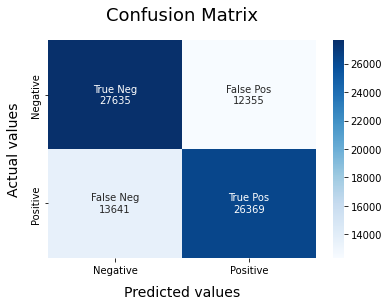

In [47]:
model_evaluate(model, X_test, Y_test)